Here we want to play around with the ONS data. This script does not serve a specific purpouse, aside from solving some doubts and provinding a playground to get familiar with the data.

It is also used to count how many OA and LSOA are in a given TTWA, to have an estimate of how many times we need to call a transport API.

In [2]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

In [3]:
folder1= '/Users/stefgarasto/Local-Data/Census/'
folder2 = '/Users/stefgarasto/Google Drive/Documents/data/'

In [4]:
file2 = folder2 + 'Not-yet-classified/agg_manchester_ttwa.csv'
file3 = folder2 + 'ONS/ONS-Postcode-Directory-Latest-Centroids.csv'
file4 = folder2 + 'ONS/population_density1.csv'
file5 = folder2 + 'ONS/Travel_to_Work_Areas_December_2011_Boundaries.csv'
file6 = folder2 + 'ONS/Output_Areas_December_2011_Population_Weighted_Centroids.csv'
file7 = folder2 + 'ONS/National_Statistics_Postcode_Lookup_UK.csv'

In [5]:
# summary of how many jobs locations in BG data
data2 = pd.read_csv(file2)
data2.head()

,City,BGTJobId,MinEdu,MaxEdu,MinSalary,MaxSalary,WorkFromHomeFlag,Latitude,Longitude
0,alderley edge,834,16.0,16.0,24000.0,26000.0,0.013189,1.0,1.0
1,altrincham,5358,12.0,14.0,21000.0,25000.0,0.010825,1.0,1.0
2,ashton-under-lyne,1878,12.0,16.0,22606.0,30000.0,0.010117,2.0,2.0
3,atherton,150,12.0,12.0,22880.0,30000.0,0.026667,1.0,1.0
4,bamford,10,13.0,16.0,36304.0,36304.0,0.100000,1.0,1.0


In [6]:
# Postcode data: to map postcodes to lat/long and ttwa
data3 = pd.read_csv(file3)
print('Columns found in the ONS postcode directory table')
print(data3.columns)
#data3.head()

/Users/stefgarasto/miniconda3/envs/transport/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (32,42,47,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Columns found in the ONS postcode directory table
Index(['X', 'Y', 'objectid', 'pcd', 'pcd2', 'pcds', 'dointr', 'doterm',
       'oscty', 'oslaua', 'osward', 'usertype', 'oseast1m', 'osnrth1m',
       'osgrdind', 'oshlthau', 'nhser', 'ctry', 'rgn', 'ced', 'pcon', 'eer',
       'teclec', 'ttwa', 'pct', 'nuts', 'statsward', 'oa01', 'casward', 'park',
       'lsoa01', 'msoa01', 'ur01ind', 'oac01', 'oa11', 'lsoa11', 'msoa11',
       'parish', 'wz11', 'ccg', 'bua11', 'buasd11', 'ru11ind', 'oac11', 'lat',
       'long', 'lep1', 'lep2', 'pfa', 'imd', 'calncv', 'stp', 'streg'],
      dtype='object')


In [7]:
print('Showing how many OAs there are, how many TTWA and how many postcodes, plus examples of them')
print(data3[['oa11','ttwa','pcd']].describe())
data3[['oa11','ttwa','pcd','X','Y']].head()


Showing how many OAs there are, how many TTWA and how many postcodes, plus examples of them
             oa11       ttwa      pcd
count     2607115    2607115  2616838
unique     232034        230  2616838
top     L99999999  E30000234  E1  0YQ
freq         6900     315479        1


,oa11,ttwa,pcd,X,Y
0,S00089106,S22000047,AB1 3QF,-2.073663,57.137910
1,S00089104,S22000047,AB1 3QH,-2.078354,57.137306
2,S00089104,S22000047,AB1 3QJ,-2.079230,57.137287
3,S00090590,S22000047,AB1 3QL,-2.080454,57.137825
4,S00090590,S22000047,AB1 3QN,-2.080287,57.137241


In [8]:
#for ii,pc in enumerate(data3['pcd']):
#    if 'SE232UP' in pc:
#        print(ii)
#print(data3['pcd'][data3['oa11'] == 'E00016756']) #35
#print(data3['pcd'][data3['oa11'] == 'E00173704'])
#print(data3[['pcd','pcd2','oa11','ttwa']].loc[2032545:2032563])

In [9]:
# travel to work areas: list of names and boundaries (not sure how to use the boundaries)
data5 = pd.read_csv(file5)
data5.head()

,objectid,ttwa11cd,ttwa11nm,st_areashape,st_lengthshape
0,1,E30000004,Barnsley,3.424767e+08,131741.189828
1,2,E30000018,Bradford,3.439266e+08,123178.197969
2,3,E30000046,Dorchester and Weymouth,7.199390e+08,232334.633989
3,4,E30000054,Grantham,7.779521e+08,189238.098641
4,5,E30000061,Hastings,4.567289e+08,144067.660554


(array([4.6125e+04, 0.0000e+00, 0.0000e+00, 4.5370e+03, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

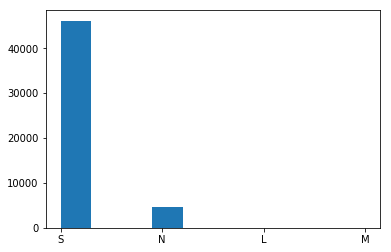

In [10]:
# Load the population weighted centroids for the OAs. However, these are only for England and Wales OAs
# (see also histograms below)
data6 = pd.read_csv(file6)
data6['oa11cd'].describe()
# There are only 181408 OAs in England and wales, while the ONS postcode directory dataset contains also those
# in Scotland and Northern Ireland. Indeed, if we get the difference...
C = set(data3['oa11']).difference(set(data6['oa11cd']))
# ... then plot the distribution of first letters for OAs in the ONS pc directory 
# but not in the list with weighted centroids
plt.hist([x[0] for x in list(C)[1:]])

(array([171372.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  10036.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

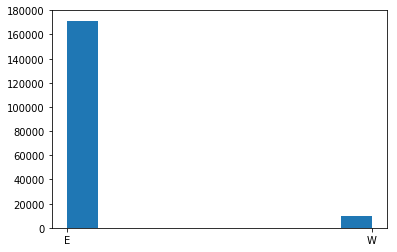

In [11]:
# As opposed to the distribution of first letters for OAs with weighted centroids ...
plt.hist([x[0] for x in list(data6['oa11cd'])])

(array([ 222733.,       0., 2174716.,       0.,   58886.,       0.,
         137860.,       0.,    6900.,    6020.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

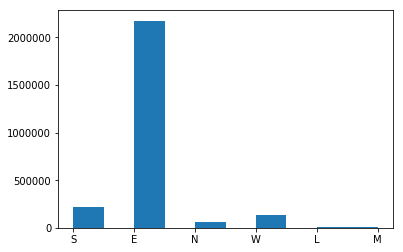

In [12]:
# ... and the distribution of first letters for all OAs in the ONS pc directory
plt.hist([x[0] for x in list(data3['oa11']) if not isinstance(x, float)])

In [13]:
# Load the National statistics postcode lookup table, whose usage is recommended for statistical purposes because
# it's based on OAs and thus more easily linkable with the census
data7 = pd.read_csv(file7)
print('Columns found in the National statistics postcode lookup table')
print(data7.columns)
print('TTWAs are not here, so I have to use the ONS postcode directory dataset')
data7[['Postcode 1', 'Postcode 2','Lower Super Output Area Code',
       'Lower Super Output Area Name', 'Middle Super Output Area Code',
       'Middle Super Output Area Name', 'Output Area Classification Code',
       'Output Area Classification Name', 'Longitude', 'Latitude',
       'Spatial Accuracy', 'Location']].head()

Columns found in the National statistics postcode lookup table
Index(['Postcode 1', 'Postcode 2', 'Postcode 3', 'Date Introduced',
       'User Type', 'Easting', 'Northing', 'Positional Quality', 'County Code',
       'County Name', 'Local Authority Code', 'Local Authority Name',
       'Ward Code', 'Ward Name', 'Country Code', 'Country Name', 'Region Code',
       'Region Name', 'Parliamentary Constituency Code',
       'Parliamentary Constituency Name', 'European Electoral Region Code',
       'European Electoral Region Name', 'Primary Care Trust Code',
       'Primary Care Trust Name', 'Lower Super Output Area Code',
       'Lower Super Output Area Name', 'Middle Super Output Area Code',
       'Middle Super Output Area Name', 'Output Area Classification Code',
       'Output Area Classification Name', 'Longitude', 'Latitude',
       'Spatial Accuracy', 'Last Uploaded', 'Location', 'Socrata ID'],
      dtype='object')
TTWAs are not here, so I have to use the ONS postcode directory d

,Postcode 1,Postcode 2,Lower Super Output Area Code,Lower Super Output Area Name,Middle Super Output Area Code,Middle Super Output Area Name,Output Area Classification Code,Output Area Classification Name,Longitude,Latitude,Spatial Accuracy,Location
0,SO166AW,SO16 6AW,E01017253,Southampton 010D,E02003558,Southampton 010,4A2,Multicultural metropolitans;Rented family livi...,-1.438832,50.931850,Postcode Level,"(50.93185, -1.438832)"
1,BD229LP,BD22 9LP,E01010858,Bradford 023E,E02002205,Bradford 023,5B3,Urbanites;Ageing urban living;Self-sufficient ...,-1.953889,53.809428,Postcode Level,"(53.809428, -1.953889)"
2,BT748EY,BT74 8EY,95PP07W1,Derrygonnelly,N99999999,(pseudo) Northern Ireland,1A1,Rural residents;Farming communities;Rural work...,-7.768846,54.379164,Postcode Level,"(54.379164, -7.768846)"
3,SA4 9BB,SA4 9BB,W01000838,Swansea 004E,W02000171,Swansea 004,8A2,Hard-pressed living;Industrious communities;In...,-4.010763,51.672133,Postcode Level,"(51.672133, -4.010763)"
4,S8 0ZE,S8 0ZE,E01007983,Sheffield 053D,E02001663,Sheffield 053,5A3,Urbanites;Urban professionals and families;Fam...,-1.484509,53.350839,Postcode Level,"(53.350839, -1.484509)"


In [14]:
# find how many OAs there are in the Manchester TTWA
ttwa_target = 'E30000239'
data3_man = data3[data3['ttwa'] == ttwa_target]
# check how many unique OAs
print('In the Manchester TTWA, there are {} unique OAs and {} unique LSOAs'.format(
    data3_man['oa11'].describe()['unique'],data3_man['lsoa11'].describe()['unique']))

In the Manchester TTWA, there are 8490 unique OAs and 1629 unique LSOAs


In [15]:
# repeat the above for all ttwa areas and check the average number of unique OAs
unique_oas = []
for ttwa0 in data5['ttwa11cd']:
    data3_tmp = data3[data3['ttwa'] == ttwa0]
    # check how many unique LSOAs
    unique_oas.append(data3_tmp['lsoa11'].describe()['unique'])

In [23]:
# for each TTWA, print the name and how many LSOAs there are:
col_width = 35
print("".join(word.ljust(col_width) for word in ['TTWA name', 'TTWA code', 'Nb of LSOA']))
for ii,ttwa0 in enumerate(data5['ttwa11nm']):
    l = [ttwa0, data5['ttwa11cd'].loc[ii], '{}'.format(unique_oas[ii])]
    print("".join(word.ljust(col_width) for word in l))
    #print('{}, with code {}, has {} LSOAs'.format(ttwa0, data5['ttwa11cd'].loc[ii], unique_oas[ii]))

TTWA name                          TTWA code                          Nb of LSOA                         
Barnsley                           E30000004                          158                                
Bradford                           E30000018                          313                                
Dorchester and Weymouth            E30000046                          71                                 
Grantham                           E30000054                          44                                 
Hastings                           E30000061                          107                                
Isle of Wight                      E30000070                          89                                 
Lancaster and Morecambe            E30000076                          89                                 
Middlesbrough and Stockton         E30000093                          304                                
Minehead                           E30000095  

In [ ]:
print('On average, there are {} unique OAs per TTWA, for {} TTWAs in total.'.format(
    print(len(unique_oas),np.mean(unique_oas))))
plt.hist(unique_oas)
plt.xlabel('number of unique OAs')
plt.ylabel('counts of ttwa with a certain amount of unique OAs')

In [45]:
prop_job_oa = 0.3 # percentange of OA with larger number of jobs to use
mean_calls = prop_job_oa* np.mean(unique_oas)**2
tot_calls = 0
for oa in unique_oas:
    tot_calls += oa*(prop_job_oa*oa)
print('To process all TTWA I''ll need {:d} calls. On average for one TTWA I''ll need {:d} calls'.format(
    int(tot_calls),int(mean_calls)))

To process all TTWA Ill need 11903283 calls. On average for one TTWA Ill need 10482 calls
